#### ¿Dónde está alojada la base de datos?

La base **SQLite** está alojada localmente en un archivo llamado `mi_base.sqlite`.  
No requiere servidor: todo ocurre de forma local.

---

#### ¿Qué motor de base de datos se utiliza?

Se utiliza **SQLite**, un motor ligero ideal para bases de datos **pequeñas y medianas**.  
Es embebido, no necesita configuración de servidor ni instalación adicional.

---

#### ¿Cómo nos conectamos a la base de datos?

Se utiliza el módulo `sqlite3` de Python (incluido en la librería estándar).  
La conexión se realiza con:

```python
conn = sqlite3.connect("mi_base.sqlite")

conn.execute(...)         # Para comandos directos
pd.read_sql(query, conn)  # Para cargar resultados como DataFrame

In [1]:
import sqlite3
import pandas as pd

# Mostrar todas las columnas al imprimir
pd.set_option('display.max_columns', None)

# Leer CSV con pandas
df = pd.read_csv("./archive/alquiler_02_11_2023cc.csv")

# Conectar (o crear) base SQLite local
conn = sqlite3.connect("mi_base.sqlite")

# Cargar el DataFrame a una tabla llamada 'alquileres'
df.to_sql('alquileres', conn, if_exists='replace', index=False)

# Consultar las primeras 5 filas con SQL
query = "SELECT * FROM alquileres LIMIT 5;"
df_head = pd.read_sql(query, conn)

print(df_head)


   Unnamed: 0  id                                               link  \
0           0   1  https://www.portalinmobiliario.com/mlc-1321634...   
1           1   2  https://www.portalinmobiliario.com/mlc-1321564...   
2           2   3  https://www.portalinmobiliario.com/mlc-1321897...   
3           3   4  https://www.portalinmobiliario.com/mlc-1318618...   
4           4   5  https://www.portalinmobiliario.com/mlc-1321526...   

                                            titulo     precio  \
0  edificio av. departamental- vista norte piso 16   400000.0   
1     edificio garcía reyes- vista poniente piso 5   410000.0   
2      edificio arquería- vista norponiente piso 3  1950000.0   
3      edificio borgetto- vista norponiente piso 1   305500.0   
4                edificio carmen- vista sur piso 2   365000.0   

                                           direction  superficie_total  \
0  av. departamental 900 - 1200, lo vial, san miguel              34.0   
1      garcía reyes 1 - 300,

Realizamos una observación del tipo de información de hay en cada columna

In [2]:
info_query = "PRAGMA table_info(alquileres);"
df_info = pd.read_sql(info_query, conn)

print(df_info)

    cid                 name     type  notnull dflt_value  pk
0     0           Unnamed: 0  INTEGER        0       None   0
1     1                   id  INTEGER        0       None   0
2     2                 link     TEXT        0       None   0
3     3               titulo     TEXT        0       None   0
4     4               precio     REAL        0       None   0
5     5            direction     TEXT        0       None   0
6     6     superficie_total     REAL        0       None   0
7     7      superficie_util     REAL        0       None   0
8     8   superficie_terraza     REAL        0       None   0
9     9            ambientes  INTEGER        0       None   0
10   10          dormitorios  INTEGER        0       None   0
11   11                banos  INTEGER        0       None   0
12   12     estacionamientos     REAL        0       None   0
13   13  cant_max_habitantes  INTEGER        0       None   0
14   14              bodegas     REAL        0       None   0
15   15 

Seleccionamos las columnas con las que nos interesaría trabajar

In [3]:
query = """
SELECT titulo, precio, direction, superficie_total, superficie_util,
       ambientes, dormitorios, banos, tipo_departamento, comuna, region, estacionamientos, bodegas
FROM alquileres;
"""

df_filtrado = pd.read_sql(query, conn)
print(df_filtrado.head())

                                            titulo     precio  \
0  edificio av. departamental- vista norte piso 16   400000.0   
1     edificio garcía reyes- vista poniente piso 5   410000.0   
2      edificio arquería- vista norponiente piso 3  1950000.0   
3      edificio borgetto- vista norponiente piso 1   305500.0   
4                edificio carmen- vista sur piso 2   365000.0   

                                           direction  superficie_total  \
0  av. departamental 900 - 1200, lo vial, san miguel              34.0   
1      garcía reyes 1 - 300, barrio yungay, santiago            5438.0   
2   arquería 1200 - 1500, rotonda atenas, las condes             190.0   
3       radal 1200 - 1500, blanqueado, quinta normal             389.0   
4             carmen 1 - 300, santa isabel, santiago              38.0   

   superficie_util  ambientes  dormitorios  banos tipo_departamento  \
0             34.0          3            2      1              None   
1             52.0    

Realizamos un análisis porcentual de datos faltantes por columna, teniendo en cuenta el siguiente criterio:


| % de valores faltantes | Acción                    |
|------------------------|-----------------------------------------------------|
| > 50%                  | Eliminar la columna                                 |
| 20% - 50%              | Evaluar si imputar o conservar según relevancia     |
| < 20%                  | Imputar los valores faltantes                       |
| 0% - 5%                | No es preocupante |


In [4]:
filas_totales = df_filtrado.shape[0]
porcentaje_faltante_columna = (df_filtrado.isna().sum() / filas_totales) * 100
print(porcentaje_faltante_columna.round(2).astype(str) + " %")


titulo                2.01 %
precio                 0.0 %
direction              0.0 %
superficie_total       0.0 %
superficie_util        0.0 %
ambientes              0.0 %
dormitorios            0.0 %
banos                  0.0 %
tipo_departamento    52.52 %
comuna                3.86 %
region                3.86 %
estacionamientos      69.7 %
bodegas              74.64 %
dtype: object


Por lo tanto, eliminamos las columnas tipo_departamento, estacionamientos y bodegas

In [5]:
query = """
SELECT titulo, precio, direction, superficie_total, superficie_util,
       ambientes, dormitorios, banos, tipo_departamento, comuna, region
FROM alquileres;
"""

df_filtrado = pd.read_sql(query, conn)
print(df_filtrado.head())

                                            titulo     precio  \
0  edificio av. departamental- vista norte piso 16   400000.0   
1     edificio garcía reyes- vista poniente piso 5   410000.0   
2      edificio arquería- vista norponiente piso 3  1950000.0   
3      edificio borgetto- vista norponiente piso 1   305500.0   
4                edificio carmen- vista sur piso 2   365000.0   

                                           direction  superficie_total  \
0  av. departamental 900 - 1200, lo vial, san miguel              34.0   
1      garcía reyes 1 - 300, barrio yungay, santiago            5438.0   
2   arquería 1200 - 1500, rotonda atenas, las condes             190.0   
3       radal 1200 - 1500, blanqueado, quinta normal             389.0   
4             carmen 1 - 300, santa isabel, santiago              38.0   

   superficie_util  ambientes  dormitorios  banos tipo_departamento  \
0             34.0          3            2      1              None   
1             52.0    

Procedemos a hacer un análisis de outliers en la variable "precio", para esto calculamos el primer cuartil (Q1) y el tercer cuartil (Q3) de la distribución de precios, y a partir de ellos obtenemos el rango intercuartílico (IQR = Q3 - Q1).

Luego, extraemos las filas donde el precio está fuera de estos límites (por debajo del límite inferior o por encima del superior) para identificar los valores extremos.

In [6]:
# Calcular Q1 y Q3 de la columna 'precio'
q1 = df_filtrado['precio'].quantile(0.25)
q3 = df_filtrado['precio'].quantile(0.75)
iqr = q3 - q1

# Calcular límites para detectar outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Límite inferior: {lower_bound}, Límite superior: {upper_bound}")

query = f"""
SELECT *
FROM alquileres
WHERE precio < {lower_bound} OR precio > {upper_bound}
"""
outliers_df = pd.read_sql(query, conn)

Límite inferior: 15000.0, Límite superior: 775000.0


Grafico el IQR (que representa la dispersión central del conjunto de datos):

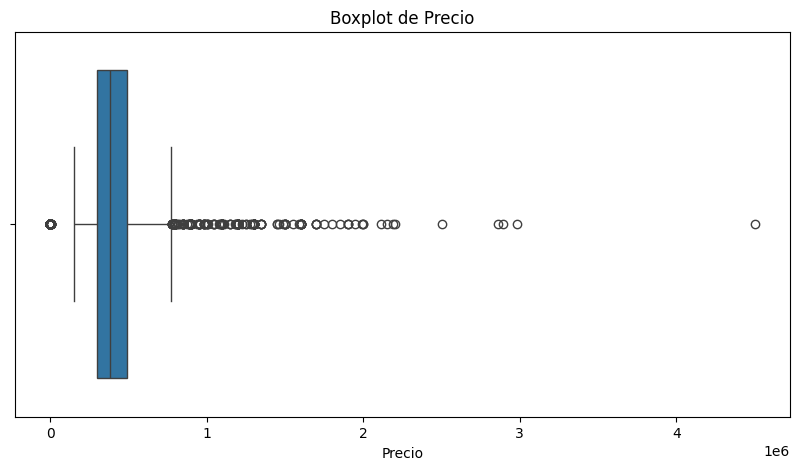

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df_filtrado['precio'])
plt.title('Boxplot de Precio')
plt.xlabel('Precio')
plt.show()

Comparamos la data previamente identificada como outliers (outliers_df) con el resto del conjunto de datos (df_filtrado) para observar el comportamiento y distribución de dichos valores atípicos en relación a la variable precio y la superficie_total.

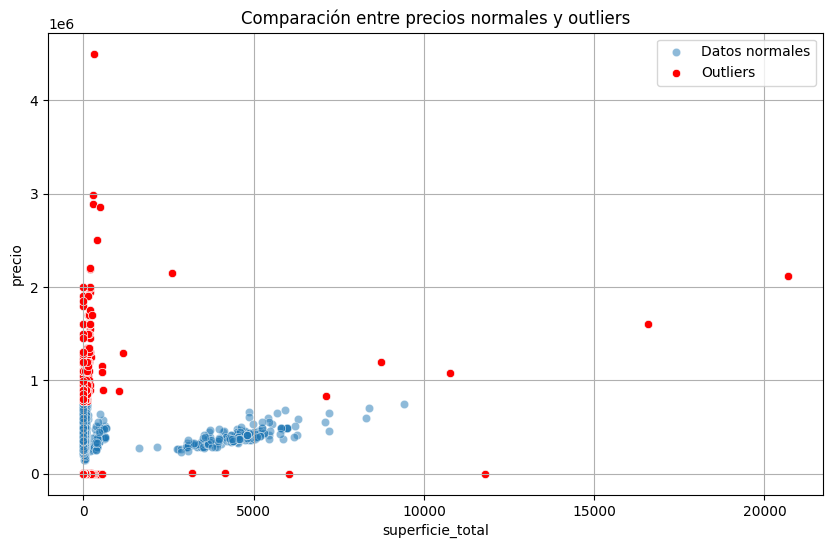

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtrado, x='superficie_total', y='precio', label='Datos normales', alpha=0.5)
sns.scatterplot(data=outliers_df, x='superficie_total', y='precio', color='red', label='Outliers')
plt.title('Comparación entre precios normales y outliers')
plt.legend()
plt.grid(True)
plt.show()


En primer lugar, observamos outliers con precios elevados pero con superficie total igual a cero, además de casos con precios de alquiler iguales a cero, lo cual es incoherente y podría afectar nuestro análisis posterior.

In [9]:
query = """
SELECT COUNT(*) AS cantidad
FROM alquileres
WHERE precio = 0
   OR superficie_total = 0
   OR superficie_util = 0
"""
resultado = pd.read_sql(query, conn)
print(f"Cantidad de filas con precio o superficie = 0: {resultado['cantidad'][0]}")



Cantidad de filas con precio o superficie = 0: 504


Borramos las filas con precio o superficie = 0

In [10]:
query_delete = """
DELETE FROM alquileres
WHERE precio = 0
   OR superficie_total = 0
   OR superficie_util = 0
"""
conn.execute(query_delete)
conn.commit()


Análizamos un nuevo caso ilógico: El hecho de que haya alquileres cuya superficie total sea menor a su superficie útil

In [11]:
# Total de filas
total_filas = pd.read_sql("SELECT COUNT(*) AS total FROM alquileres", conn)['total'][0]

# Filas con inconsistencia: superficie_total < superficie_util
query = """
SELECT COUNT(*) AS cantidad
FROM alquileres
WHERE superficie_total < superficie_util
"""
resultado = pd.read_sql(query, conn)
cantidad = resultado['cantidad'][0]

# Porcentaje
porcentaje = (cantidad / total_filas) * 100
print(f"Cantidad de filas con superficie_total < superficie_util: {cantidad}")
print(f"Porcentaje respecto al total: {porcentaje:.2f} %")


Cantidad de filas con superficie_total < superficie_util: 21
Porcentaje respecto al total: 1.46 %


Eliminamos dichas filas (que representan un 1.46% del total de los datos)

In [12]:
delete_query = """
DELETE FROM alquileres
WHERE superficie_total < superficie_util
"""

conn.execute(delete_query)
conn.commit()  # Asegura que se guarden los cambios